<a href="https://colab.research.google.com/github/MidSummersEveee/Dissertation/blob/master/MMER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

### Google Drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


### Dependencies

In [ ]:
# !pip3 -q install torch==1.9.1+cu111 torchvision==0.10.1+cu111 torchaudio==0.9.1 torchtext==0.10.1 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
!pip -qq install librosa
!pip -qq install sklearn

In [ ]:
import torch
print(torch.__version__)
print(torch.version.cuda)

1.12.1+cu113
11.3


In [ ]:
torch.cuda.is_available()

True

In [ ]:
import numpy as np
import pandas as pd
import os
import torchaudio

### Device

In [ ]:
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"
print(f"Using {device}")

Using cuda


In [ ]:
# pre-defined emotion labels
EMOTIONS = ['neu', 'ang', 'sad', 'hap']
EMOTIONS_ID = [str(i) for i in range(0, len(EMOTIONS))]
EMOTIONS_2_ID = dict(zip(EMOTIONS, EMOTIONS_ID))
ID_2_EMOTIONS = {id: emo for emo, id in EMOTIONS_2_ID.items()}

ID_2_EMOTIONS

{'0': 'neu', '1': 'ang', '2': 'sad', '3': 'hap'}

## SER-SpeechBrain

In [ ]:
!pip -q install speechbrain

     |████████████████████████████████| 496 kB 9.5 MB/s 
     |████████████████████████████████| 750.6 MB 12 kB/s 
     |████████████████████████████████| 1.3 MB 44.8 MB/s 
     |████████████████████████████████| 101 kB 10.6 MB/s 
     |████████████████████████████████| 596 kB 29.0 MB/s 
     |████████████████████████████████| 109 kB 51.2 MB/s 
     |████████████████████████████████| 546 kB 47.7 MB/s 
     |████████████████████████████████| 3.7 MB 34.8 MB/s 
     |████████████████████████████████| 3.7 MB 36.7 MB/s 
     |████████████████████████████████| 2.9 MB 36.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.13.1+cu113 requires torch==1.12.1, but you have torch 1.11.0 which is incompatible.
torchtext 0.13.1 requires torch==1.12.1, but you have torch 1.11.0 which is incompatible.


In [ ]:
# !pip -qq install transformers
!pip -qq install git+https://github.com/huggingface/transformers

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 6.6 MB 2.6 MB/s 


In [ ]:
from speechbrain.pretrained.interfaces import foreign_class
classifier = foreign_class(source="speechbrain/emotion-recognition-wav2vec2-IEMOCAP", pymodule_file="custom_interface.py", classname="CustomEncoderWav2vec2Classifier")

Downloading:   0%|          | 0.00/1.64k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

Downloading:   0%|          | 0.00/159 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/configuration_utils.py:353: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  "Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 "


Downloading:   0%|          | 0.00/380M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/wav2vec2-base were not used when initializing Wav2Vec2Model: ['quantizer.weight_proj.weight', 'project_q.weight', 'project_hid.weight', 'project_hid.bias', 'quantizer.codevectors', 'quantizer.weight_proj.bias', 'project_q.bias']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
speechbrain.lobes.models.huggingface_wav2vec - wav2vec 2.0 is frozen.


Downloading:   0%|          | 0.00/378M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/83.0 [00:00<?, ?B/s]

In [ ]:
sample_wav = '/content/drive/MyDrive/Dissertation/Speech/Ses04F_impro01_F006.wav'

In [ ]:
out_prob, score, index, text_lab = classifier.classify_file(sample_wav)

In [ ]:
print(f'sample wav predicted to be <{text_lab}> with tensor: {out_prob}')

sample wav predicted to be <['ang']> with tensor: tensor([[8.1408e-12, 1.0000e+00, 2.1454e-13, 1.9422e-13]])


In [ ]:
out_prob.shape

torch.Size([1, 4])

In [ ]:
def speech_probs(wav_url):
  out_prob, score, index, text_lab = classifier.classify_file(wav_url)
  return out_prob

## SER-CNN

### AudioDataset

In [ ]:
from torch.utils.data import Dataset

class AudioDataset(Dataset):

  def __init__(self,
        annotations_file,
        audio_dir,
        transformation,
        target_sample_rate,
        num_samples,
        device):
    '''
    Arguments:
      annotations: path to csv file
      audio_dir: path to audio dir
      transformation: any audio tranform (Mel-spec, MFCC etc) provided by torch audio
               (function pointer in fact, callable)
      target_sample_rate: as named
    '''
    Dataset.__init__(self)
    self.annotations = pd.read_csv(annotations_file)
    print(self.annotations)
    self.audio_dir = audio_dir
    self.device = device
    # print(self.device)
    self.transformation = transformation.to(self.device)
    self.target_sample_rate = target_sample_rate
    self.num_samples = num_samples
  
  def __len__(self):
    return len(self.annotations)

  def __getitem__(self, index):
    '''
    loading the waveform sample specified by the index
    
    Returns:
      signal: <transformed> waveform
      label: text in this case
    '''
    audio_sample_path = self._get_audio_sample_path(index)
    label = self._get_audio_sample_label(index)

    signal, sr = torchaudio.load(audio_sample_path)
    signal = signal.to(self.device)
    # signal = signal.cuda()
    # Note: signal has shape (num_channels, num_samples) -> (2, 16000) -> (1, 16000)

    signal = self._resample_if_necessary(signal, sr)  # resampling
    signal = self._mix_down_if_necessary(signal)    # reduce to mono-channel (aggregate over 0st dim)
    signal = self._cut_if_necessary(signal)
    signal = self._right_pad_if_necessary(signal)   # right padding (when have less than expected)
    signal = self.transformation(signal)       # apply tranformation

    return signal, label

  def _get_audio_sample_path(self, index):
    '''
    Join <dir name> & <.wav filename in df anno>
    retrieve complete index-th audio sample url

    Returns:
      path: complete i-th audio sample url
    '''

    file_name = f'{self.annotations.iloc[index, 0]}.wav' # 0st col: 'UID'
    path = os.path.join(self.audio_dir, file_name)
    return path
    
  def _get_audio_sample_label(self, index):
    # return self.annotations.iloc[index, 3] # 1st col: 'UTT' 4th: 'EMOTION'

    label1 = self.annotations.iloc[index, 3]
    # label2 = torch.from_numpy(self.annotations.iloc[index, 4:7].to_numpy().astype(np.float32))

    # return {'label1': label1, 'label2': label2}
    return {'label1': label1}

  def _cut_if_necessary(self, signal):
    if signal.shape[1] > self.num_samples:
      signal = signal[:, :self.num_samples]
    return signal

  def _right_pad_if_necessary(self, signal):
    length_signal = signal.shape[1]
    if length_signal < self.num_samples:
      num_missing_samples = self.num_samples - length_signal
      last_dim_padding = (0, num_missing_samples) #(1, 2) 1 left 2 right
      # [1, 1, 1] -> [0, 1, 1, 1, 0, 0]
      signal = torch.nn.functional.pad(signal, last_dim_padding)
    return signal

  def _resample_if_necessary(self, signal, sr):
    if sr != self.target_sample_rate:
      if self.device == "cpu":
        resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
      elif self.device == 'cuda':
        resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate).cuda()
      else:
        raise Exception("Device type error!")
      signal = resampler(signal)
    return signal

  def _mix_down_if_necessary(self, signal):
    if signal.shape[0] > 1: # i.e. (2, 1000)
      signal = torch.mean(signal, dim=0, keepdim=True)
    return signal

In [ ]:
ANNOTATIONS_FILE = "/content/drive/MyDrive/Dissertation/Datasets/cleaned_1.0/better_test_less.csv"
AUDIO_DIR = "/content/drive/MyDrive/Dissertation/Speech"

BATCH_SIZE = 64
# BATCH_SIZE = 32

EPOCHS = 10
LEARNING_RATE = 0.001

# SAMPLE_RATE = 16000
# NUM_SAMPLES = 220500 * 3

SAMPLE_RATE = 8000
NUM_SAMPLES = 8000 * 2
# NUM_SAMPLES = 16000 * 3


# instantiating our dataset object and create data loader
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
  sample_rate=SAMPLE_RATE,
  n_fft=1024,
  hop_length=512,
  n_mels=64
)

iemocap_test = AudioDataset(
      ANNOTATIONS_FILE,
      AUDIO_DIR,
      mel_spectrogram,
      SAMPLE_RATE,
      NUM_SAMPLES,
      'cpu'
      )

                         UID  \
0        Ses04F_impro06_F005   
1        Ses04F_impro03_M021   
2     Ses04M_script02_2_F019   
3        Ses03M_impro06_M020   
4        Ses03F_impro04_F023   
...                      ...   
1039  Ses01F_script03_2_M020   
1040  Ses03M_script03_2_M021   
1041     Ses04M_impro07_M007   
1042  Ses05M_script03_2_M030   
1043  Ses01M_script01_3_F016   

                                                    UTT EMOTIONS  EMOTION  \
0     He was only twenty four and just so many thing...        2        2   
1                      I know but you just asked me to-        0        0   
2     I'd rather not remember some things.  I'd rath...        2        2   
3        and then something like this happens you know?        2        2   
4                                Yeah, I guess I could.      0,2        2   
...                                                 ...      ...      ...   
1039  Oh really.  It's a pity you didn't have any br...    0,1,2        1   

### CNN Model

In [ ]:
from torch import nn
from torchsummary import summary
import torch.nn.functional as F

In [ ]:
class CNNNetwork(nn.Module):

  def __init__(self):
    super().__init__()

    # sequential convolutions  / flatten / linear / softmax
    self.convSeq = nn.Sequential(
        nn.Conv2d(
            in_channels=1,
            out_channels=16,  # 16 filters
            kernel_size=3,
            stride=1,
            padding=2
        ),
        nn.Tanh(),
        # nn.Dropout2d(0.1),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=3,
            stride=1,
            padding=2
        ),
        nn.Tanh(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=3,
            stride=1,
            padding=2
        ),
        nn.Tanh(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(
            in_channels=64,
            out_channels=128,
            kernel_size=3,
            stride=1,
            padding=2
        ),
        nn.Tanh(),
        nn.MaxPool2d(kernel_size=2),
        nn.Flatten()

    )

    # flatten
    self.flatten = nn.Flatten()

    # linear/dense
    # self.linear = nn.Linear(128 * 5 * 4, 4)
    self.linear1 = nn.Sequential(
        # nn.Linear(128 * 1 * 8, 800),
        nn.Linear(64 * 5 * 4, 400),
        nn.Tanh(),
        # nn.Linear(54000, 4000),
        # nn.Tanh(),
        # nn.BatchNorm1d(1024),
        nn.Linear(400, 4)
    )

    # VAD
    # self.linear2 = nn.Sequential(
    #     nn.Linear(64 * 5 * 4, 512),
    #     nn.Tanh(),
    #     nn.Linear(512, 300),
    #     nn.Tanh(),
    #     # nn.BatchNorm1d(1024),
    #     nn.Linear(300, 3)
    # )

    # softmax
    self.softmax = nn.Softmax(dim=1)
  
  # how to pass data through layers
  def forward(self, input_data):

    one = input_data[:,:,:, 0:input_data.shape[-1] // 4]
    two = input_data[:,:,:, input_data.shape[-1] // 4: input_data.shape[-1] // 4 * 2]
    thr = input_data[:,:,:, input_data.shape[-1] // 4 * 2:input_data.shape[-1] // 4 * 3]
    fou = input_data[:,:,:, input_data.shape[-1] // 4 * 3:input_data.shape[-1] // 4 * 4]

    one = self.convSeq(one)
    two = self.convSeq(two)
    thr = self.convSeq(thr)
    fou = self.convSeq(fou)

    # x = torch.cat((one,two,thr,fou), -1)
    # x = torch.cat((one,two,thr,fou), 0)

    x = torch.add(one, two)
    x = torch.add(x, thr)
    x = torch.add(x, fou)
    # x = one+two+thr+fou
    x = x * 0.25

    # x = F.pad(x, pad=(0, 0, 0, 1920 - x.shape[0]))
    # print(x.shape)
    x.to(device)

    x1 = self.linear1(x)
    # x2 = self.linear2(x)

    x1 = self.softmax(x1)
    # return x1, x2
    return x1

In [ ]:
# BATCH_SIZE = 128
# EPOCHS = 10
# LEARNING_RATE = 0.001

# SAMPLE_RATE = 16000
# NUM_SAMPLES = 22050

In [ ]:
# cnn_path = "/content/drive/MyDrive/Dissertation/Models/SER/clean_1.0/CNN_VAD_long.pth"
# cnn_path = "/content/drive/MyDrive/Dissertation/Models/SER/clean_1.0/CNN_series.pth"
cnn_path = "/content/drive/MyDrive/Dissertation/Models/SER/clean_1.0/CNN_series_no_vad_new.pth"

In [ ]:
cnn_model = CNNNetwork()
state_dict = torch.load(cnn_path)
cnn_model.load_state_dict(state_dict)

<All keys matched successfully>

### CNN Probs

In [ ]:
def cnn_probs(num, dataset=iemocap_test, silence=True):
  
  with torch.no_grad():
    X = dataset[num][0]
    X.unsqueeze_(0)
    probs = cnn_model(X)
    # probs, vad = cnn_model(X)
  return probs

In [ ]:
csample = cnn_probs(0)

In [ ]:
csample.shape

torch.Size([1, 4])

## TER-Bert

In [ ]:
!pip install -q -U watermark
!pip install -qq transformers

     |████████████████████████████████| 1.6 MB 8.0 MB/s 
     |████████████████████████████████| 4.7 MB 6.8 MB/s 
     |████████████████████████████████| 101 kB 12.7 MB/s 
     |████████████████████████████████| 6.6 MB 45.9 MB/s 
     |████████████████████████████████| 596 kB 60.3 MB/s 


In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.13
IPython version      : 7.9.0

numpy       : 1.21.6
pandas      : 1.3.5
torch       : 1.12.1+cu113
transformers: 4.21.1



In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import shutil
import sys
from transformers import BertTokenizer, BertModel

In [ ]:
MAX_LEN = 120
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 5
LEARNING_RATE = 1e-05

In [ ]:
def load_ckp(checkpoint_fpath, model, optimizer):
  '''
  checkpoint_path: path to save checkpoint
  model: model that we want to load checkpoint parameters into
  optimizer: optimizer we defined in previous training
  '''
  # load check point
  checkpoint = torch.load(checkpoint_fpath)
  model.load_state_dict(checkpoint['state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer'])
  valid_loss_min = checkpoint['valid_loss_min']
  return model, optimizer, checkpoint['epoch'], valid_loss_min # we use .item() to get rid of the tensor form


def save_ckp(state, is_best, checkpoint_path, best_model_path):
  '''
  state: checkpoint we want to save
  is_best: is this the best checkpoint; min validation loss
  checkpoint_path: path to save checkpoint
  best_model_path: path to save best model
  '''
  f_path = checkpoint_path
  # save checkpoint data to the path given, checkpoint_path
  torch.save(state, f_path)

   # if it is a best model, min validation loss
  if is_best:
    best_fpath = best_model_path
    # copy that checkpoint file to best path given, best_model_path
    shutil.copyfile(f_path, best_fpath)

In [ ]:
class BERTClass(torch.nn.Module):
  def __init__(self):
    super(BERTClass, self).__init__()
    self.bert_model = BertModel.from_pretrained('bert-base-cased', return_dict=True)
    self.dropout = torch.nn.Dropout(0.3)
    self.linear = torch.nn.Linear(768, 4)

  def forward(self, input_ids, attention_mask, token_type_ids):

    # every time we get 2 outputs
    # seuqence output & pooler output, in classification task final layer we need only the later

    output = self.bert_model(input_ids, attention_mask, token_type_ids)
    output_dropout = self.dropout(output.pooler_output)
    output = self.linear(output_dropout)  # note that our final layer is a linear layer
    return output

In [ ]:
model = BERTClass()
model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [ ]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

In [ ]:
ckpt_path = "/content/drive/MyDrive/Dissertation/Models/TER_final/curr_ckpt"
best_model_path = "/content/drive/MyDrive/Dissertation/Models/TER_final/best_model.pt"

# ckpt_path = "/content/drive/MyDrive/Dissertation/Models/TER_final/true_curr_ckpt"
# best_model_path = "/content/drive/MyDrive/Dissertation/Models/TER_final/true_best_model.pt"

model, optimizer, epoch, valid_loss_min_value = load_ckp(ckpt_path, model, optimizer)

In [ ]:
model.eval()

BERTClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

### Load Checkpoint

In [ ]:
# remote_data_path = "/content/drive/MyDrive/Dissertation/Datasets/dataset_TER/"
# df_test = pd.read_csv(''.join([remote_data_path, 'test.csv']), index_col=0)

df_test = pd.read_csv("/content/drive/MyDrive/Dissertation/Datasets/cleaned_1.0/better_test_less.csv")

In [ ]:
df_test.shape

(1044, 5)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

### Bert Probs

In [ ]:
def bert_probs(num, silence=True):
  example = df_test['UTT'][num]
  encodings = tokenizer.encode_plus(
      example,
      None,
      add_special_tokens=True,
      max_length=MAX_LEN,
      padding='max_length',
      return_token_type_ids=True,
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt'
  )

  with torch.no_grad():
    input_ids = encodings['input_ids'].to(device, dtype=torch.long)
    attention_mask = encodings['attention_mask'].to(device, dtype=torch.long)
    token_type_ids = encodings['token_type_ids'].to(device, dtype=torch.long)
    output = model(input_ids, attention_mask, token_type_ids)
    final_output = torch.sigmoid(output).cpu().detach().numpy().tolist()
    
    if not silence:
      print(f'Text: [{example}]')
      print(f'Emotion: [{EMOTIONS[int(np.argmax(final_output, axis=1))]}]')
      print('-'*10)
      sigmoids = dict(zip(EMOTIONS, final_output[0]))
      for emo, value in sigmoids.items():
        print(f'{emo} : {value}')
    
    else:
      # return EMOTIONS_ID[int(np.argmax(final_output, axis=1))]
      return torch.FloatTensor(final_output)

In [ ]:
bsample = bert_probs(0)

In [ ]:
bsample.shape

torch.Size([1, 4])

## Multimodal

In [ ]:
assert csample.dtype == bsample.dtype, 'logits data type does not match'

In [ ]:
csample

tensor([[3.5527e-01, 9.3152e-04, 6.4328e-01, 5.1922e-04]])

In [ ]:
bsample

tensor([[0.3982, 0.2015, 0.9674, 0.3285]])

In [ ]:
def fusion(df, speech_func, text_func, ratio=0.3):

  size = len(df.index)
  pos = 0

  y_pred = []
  
  for i in range(size):
    
    speech_probs = speech_func(i)
    text_probs = text_func(i)

    if ratio == 0:
      fusion_probs = text_probs
    elif ratio == 1:
      fusion_probs = speech_probs
    else:
      fusion_probs = ratio * speech_probs + (1-ratio) * text_probs

    # predicted emo_id
    emo_id = fusion_probs[0].argmax(0).item()
    y_pred.append(emo_id)
    emo_id = ID_2_EMOTIONS[str(emo_id)]

    # if emo_id is positive in the test df
    if df.iloc[i, df.columns.get_loc(emo_id)] == 1:
      pos += 1

  print(f'total precision: {pos / size * 100}%')
  # print(y_pred[:4])
  y_pred = np.eye(4)[y_pred]
  # print(y_pred[:4])
  return y_pred
    
y_pred = fusion(df_test, cnn_probs, bert_probs)

total precision: 71.64750957854406%


In [ ]:
from sklearn.metrics import classification_report
import seaborn as sns

### Multiclass Classification

In [ ]:
# df_test = pd.read_csv("/content/drive/MyDrive/Dissertation/Datasets/cleaned_1.0/better_test_less.csv")
y_true = df_test[['neu', 'ang', 'sad', 'hap']].to_numpy()
c_multi_class = classification_report(y_true, y_pred, target_names=EMOTIONS, zero_division=1)
print(c_multi_class)

              precision    recall  f1-score   support

         neu       0.62      0.75      0.68       323
         ang       0.78      0.76      0.77       219
         sad       0.71      0.80      0.75       230
         hap       0.85      0.57      0.68       272

   micro avg       0.72      0.72      0.72      1044
   macro avg       0.74      0.72      0.72      1044
weighted avg       0.73      0.72      0.72      1044
 samples avg       0.72      0.72      0.72      1044



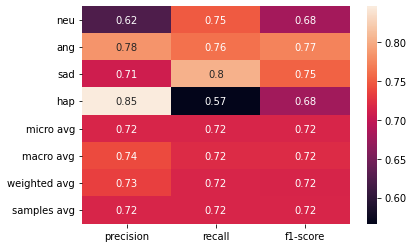

In [ ]:
map_c = classification_report(y_true, y_pred, target_names=EMOTIONS, zero_division=1, output_dict=True)
sns.heatmap(pd.DataFrame(map_c).iloc[:-1, :].T, annot=True)

In [ ]:
map_c['macro avg']['recall']

0.7205768451231782

### Multilabel Classification

In [ ]:
df_test_m = pd.read_csv("/content/drive/MyDrive/Dissertation/Datasets/cleaned_1.0/better_test_less.csv")
y_true_m = df_test_m[['neu_m', 'ang_m', 'sad_m', 'hap_m']].to_numpy()
c_multi_label = classification_report(y_true_m, y_pred, target_names=EMOTIONS, zero_division=1)
print(c_multi_label)

              precision    recall  f1-score   support

         neu       0.72      0.62      0.67       454
         ang       0.81      0.69      0.75       251
         sad       0.77      0.74      0.75       269
         hap       0.81      0.53      0.64       279

   micro avg       0.77      0.64      0.70      1253
   macro avg       0.78      0.64      0.70      1253
weighted avg       0.77      0.64      0.69      1253
 samples avg       0.77      0.68      0.71      1253



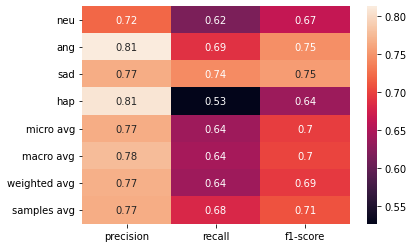

In [ ]:
map_l = classification_report(y_true_m, y_pred, target_names=EMOTIONS, zero_division=1, output_dict=True)
sns.heatmap(pd.DataFrame(map_l).iloc[:-1, :].T, annot=True)

In [ ]:
map_l['macro avg']['recall']
map_l['samples avg']['precision']

0.7662835249042146

### Visualization

In [ ]:
# df_l = pd.DataFrame(map_l).drop(['support'], axis=0).drop(['macro avg', 'weighted avg', 'samples avg'], axis=1)
# df_l

Helper function to loop trough nested dict.

In [ ]:
def nested_dict_pairs_iterator(dict_obj):
    ''' This function accepts a nested dictionary as argument
        and iterate over all values of nested dictionaries
    '''
    # Iterate over all key-value pairs of dict argument
    for key, value in dict_obj.items():
        # Check if value is of dict type
        if isinstance(value, dict):
            # If value is dict then iterate over all its values
            for pair in  nested_dict_pairs_iterator(value):
                yield (key, *pair)
        else:
            # If value is not dict type then yield the value
            yield (key, value)
#Loop through all key-value pairs of a nested dictionary
# for pair in nested_dict_pairs_iterator(map_c):
#   print(pair)

Inspect the curve of main metrics over a series of fusion ratios.

In [ ]:
RATIOS = [0, 0.1, 0.3, 0.4, 0.5, 1]

def group():

  total = {}
  
  y_true_m = df_test_m[['neu_m', 'ang_m', 'sad_m', 'hap_m']].to_numpy()

  for r in RATIOS:
    y_pred = fusion(df_test, cnn_probs, bert_probs, r)
    # map = classification_report(y_true_m, y_pred, target_names=EMOTIONS, zero_division=1, output_dict=True)
    map = classification_report(y_true, y_pred, target_names=EMOTIONS, zero_division=1, output_dict=True)
    total[r] = map
  
  data = [pair for pair in nested_dict_pairs_iterator(total)]
  df = pd.DataFrame(data, columns=['Ratio', 'Emotion', 'Metric', 'Value'])
  return df

info = group()

total precision: 67.91187739463601%
total precision: 69.73180076628353%
total precision: 71.64750957854406%
total precision: 67.33716475095785%
total precision: 58.04597701149425%
total precision: 53.16091954022989%


In [ ]:
info

,Ratio,Emotion,Metric,Value
0,0.0,neu,precision,0.605797
1,0.0,neu,recall,0.647059
2,0.0,neu,f1-score,0.625749
3,0.0,neu,support,323.000000
4,0.0,ang,precision,0.770000
...,...,...,...,...
187,1.0,weighted avg,support,1044.000000
188,1.0,samples avg,precision,0.531609
189,1.0,samples avg,recall,0.531609
190,1.0,samples avg,f1-score,0.531609


In [ ]:
import seaborn as sns
sns.set_theme(style="whitegrid")

#### Precision Trends

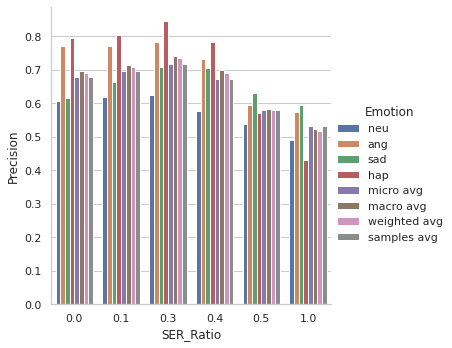

In [ ]:
info_precision = info[info['Metric']=='precision']

info_precision = info_precision.rename(columns={"Ratio": "SER_Ratio", "Value": "Precision"})

pp = \
sns.catplot(x = "SER_Ratio",       # x variable name
      y = "Precision",       # y variable name
      hue = "Emotion",     # group variable name
      data = info_precision,     # dataframe to plot
      kind = "bar")
pp.fig.savefig("/content/drive/MyDrive/Dissertation/Visual/8.APP_precision_no_vad.svg")

#### Recall Trends

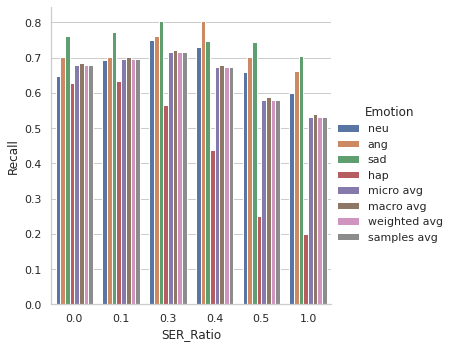

In [ ]:
info_recall = info[info['Metric']=='recall']

info_recall = info_recall.rename(columns={"Ratio": "SER_Ratio", "Value": "Recall"})

pr = \
sns.catplot(x = "SER_Ratio",       # x variable name
      y = "Recall",       # y variable name
      hue = "Emotion",     # group variable name
      data = info_recall,     # dataframe to plot
      kind = "bar")
pr.fig.savefig("/content/drive/MyDrive/Dissertation/Visual/8.APP_recall_no_vad.svg")

#### F1-score Trends

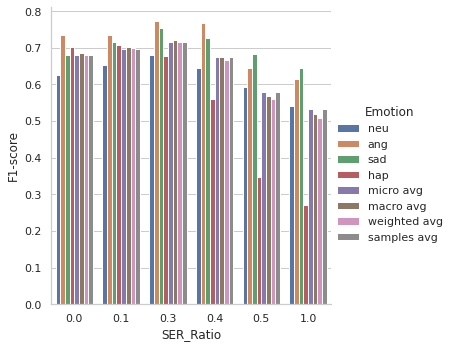

In [ ]:
info_f = info[info['Metric']=='f1-score']

info_f = info_f.rename(columns={"Ratio": "SER_Ratio", "Value": "F1-score"})

pf = \
sns.catplot(x = "SER_Ratio",       # x variable name
      y = "F1-score",       # y variable name
      hue = "Emotion",     # group variable name
      data = info_f,     # dataframe to plot
      kind = "bar")

pf.fig.savefig("/content/drive/MyDrive/Dissertation/Visual/8.APP_f1_no_vad.svg")

### Check Best Ratio

In [ ]:
info[(info['Metric']=='precision') & (info['Ratio'] == 1)]
# info[info['Metric']=='recall']

,Ratio,Emotion,Metric,Value
160,1.0,neu,precision,0.491139
164,1.0,ang,precision,0.575397
168,1.0,sad,precision,0.595588
172,1.0,hap,precision,0.432000
176,1.0,micro avg,precision,0.531609
180,1.0,macro avg,precision,0.523531
184,1.0,weighted avg,precision,0.516417
188,1.0,samples avg,precision,0.531609
